<a href="https://colab.research.google.com/github/alexbolduin/Deep_Learning_School_2020-2021_base/blob/master/ChernyshevAlexander_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Compllited tasks:


*   Vanilla Autoencoder
*   Variational Autoencoder
*   Denoising
*   Occlusion







# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


**Main functions**

In [ ]:
import numpy as np
import os
from skimage.transform import resize
import skimage.io
import pandas as pd

def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=45,dimy=45
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs


def ten_imgshow(data, start_idx):

  plt.figure(figsize=(30, 3))
  indexes = list(range(start_idx, start_idx + 10))
  for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(data[indexes[i]])
    plt.axis('off')
    plt.grid(False);


def plot(train_history, val_history):

  plt.figure(figsize=(15, 9))
  plt.plot(train_history, label="train_loss")
  plt.plot(val_history, label="valid_loss")
  plt.legend(loc='best')
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.grid(True)
  plt.show();


def train(train_loader, val_loader, data_dim, optimizer, 
          criterion, model, device, epochs, modify=None):

  train_history = []
  valid_history = []

  for epoch in range(epochs):
    train_loss = 0
    valid_loss = 0
    for batch in train_loader:
      model.train()
      optimizer.zero_grad()
      if modify != None:
        mod_batch = modify(batch, device)
        mod_batch = mod_batch.view(-1, data_dim).float().to(device)
        batch = batch.view(-1, data_dim).float().to(device)
        outputs, _ = model(mod_batch)
      else:
        batch = batch.view(-1, data_dim).float().to(device)
        outputs, _ = model(batch)

      t_loss = criterion(outputs, batch)
      t_loss.backward()
      optimizer.step()

      train_loss += t_loss.item()
    for batch in val_loader:
      model.eval()
      if modify != None:
        mod_batch = modify(batch, device)
        mod_batch = mod_batch.view(-1, data_dim).float().to(device)
        batch = batch.view(-1, data_dim).float().to(device)
        val_preds, _ = model(mod_batch)
      else:
        batch = batch.view(-1, data_dim).float().to(device)
        val_preds, _ = model(batch)

      v_loss = criterion(val_preds, batch) 

      valid_loss += v_loss.item()

    train_loss = train_loss / len(train_loader)
    valid_loss = valid_loss / len(val_loader)

    train_history.append(train_loss)
    valid_history.append(valid_loss)

    if epoch == 0:
      print(f'epoch : {epoch}/{epochs}, train_loss = {train_loss}, valid_loss = {valid_loss}')
    elif (epoch + 1) % 50 == 0:
      print(f'epoch : {epoch + 1}/{epochs}, train_loss = {train_loss}, valid_loss = {valid_loss}')

  model.eval()

  return model, train_history, valid_history


def train_vae(train_loader, val_loader, data_dim, optimizer, 
              criterion, model, device, epochs):

  train_history = []
  valid_history = []

  for epoch in range(epochs):
    train_loss = 0
    valid_loss = 0
    for batch in train_loader:
      model.train()
      optimizer.zero_grad()

      batch = batch.view(-1, data_dim).float().to(device)
      outputs, mu, logsigma = model(batch)

      t_loss = criterion(batch, mu, logsigma, outputs)
      t_loss.backward()
      optimizer.step()

      train_loss += t_loss.item()
    for batch in val_loader:
      model.eval()
  
      batch = batch.view(-1, data_dim).float().to(device)
      val_preds, mu, logsigma = model(batch)

      v_loss = criterion(batch, mu, logsigma, val_preds) 

      valid_loss += v_loss.item()

    train_loss = train_loss / len(train_loader)
    valid_loss = valid_loss / len(val_loader)

    train_history.append(train_loss)
    valid_history.append(valid_loss)

    if epoch == 0:
      print(f'epoch : {epoch}/{epochs}, train_loss = {train_loss}, valid_loss = {valid_loss}')
    elif (epoch + 1) % 50 == 0:
      print(f'epoch : {epoch + 1}/{epochs}, avg_train_loss = {np.mean(train_history)}, avg_valid_loss = {np.mean(valid_history)}')

  model.eval()

  return model, train_history, valid_history

# Vanilla Autoencoder (2 балла)

## Prepare the data


In [ ]:
import numpy as np
from sklearn.manifold import TSNE
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from copy import deepcopy
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline


In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
#from get_dataset import fetch_dataset
data, attrs = fetch_dataset()


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
#<тут Ваш код>
data_size = data.shape[0]
idxs = list(range(data_size))
val_split = 0.2
split = int(np.floor(val_split * data_size))
np.random.shuffle(idxs)

train_idxs, val_idxs = idxs[split:], idxs[:split]

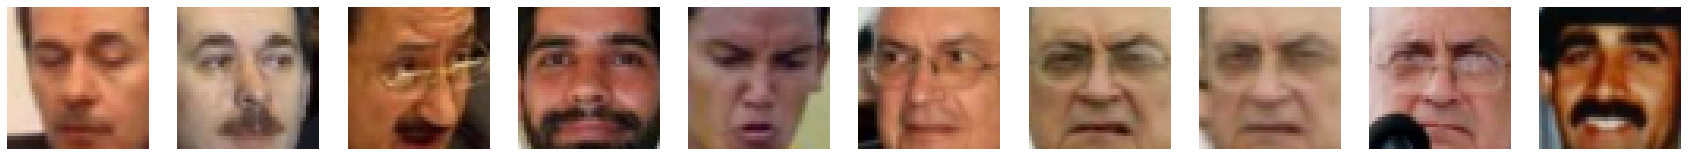

In [ ]:
ten_imgshow(data, 49)

In [ ]:
class ImgData(Dataset):
  def __init__(self, data, transform=None):
    self.data = data
    self.transform = transform

  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self, index):
    self.img = torch.tensor(self.data[index])

    if self.transform:
      self.img = self.transform(self.img.reshape(3, 45, 45))

    return self.img.reshape(45, 45, 3)

In [ ]:
ae_train_ds = ImgData(data[train_idxs])
ae_val_ds = ImgData(data[val_idxs])

**Random example**

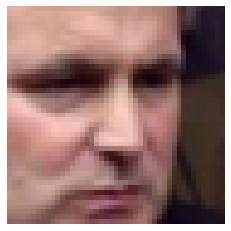

In [ ]:
frame = ae_train_ds.__getitem__(1)
plt.imshow(frame)
plt.axis('off')
plt.grid(False)

## Autoencoder
В этом разделе мы напишем и обучем обычный автоэнкодер.

Надеюсь, что к этому моменту вы уже почитали про автоэнкодеры и знаете, зачем они нужны и какова их архитектура. Если нет, то начните с этих ссылок: 

https://habr.com/ru/post/331382/ \\
https://towardsdatascience.com\intuitively-understanding-variational-autoencoders-1bfe67eb5daf



<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

^ вот так выглядит автоэнкодер

In [ ]:
#dim_code = <your code here> # выберите размер латентного вектора, т.е. code, самой "узкой" части автоэнкодера

data_dim = frame.shape[0] * frame.shape[1] * frame.shape[2]
dim_code = int(588)
print(dim_code, data_dim)

588 6075


Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

**AE model**

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, dim_code):
      super(Autoencoder, self).__init__()
      self.dim_code = dim_code # latent layer size
      self.encoder_hidden = nn.Sequential(nn.Linear(6075, 6075),
                                          nn.ReLU())
      self.code = nn.Linear(6075, self.dim_code)
      self.activation = nn.ReLU()
      self.decoder_hidden = nn.Sequential(nn.Linear(self.dim_code, 6075),
                                          nn.ReLU())
      self.decoder_output = nn.Sequential(nn.Linear(6075, 6075),
                                          nn.Sigmoid())
        
    def forward(self, x, change=None):

      encode = self.encoder_hidden(x)
      latent_code = self.code(encode)

      if change != None:
        latent_code = latent_code + change

      activation = self.activation(latent_code)
      decode = self.decoder_hidden(activation)
      reconstruction = self.decoder_output(decode)
        
      return reconstruction, latent_code

In [ ]:
criterion = nn.MSELoss()

autoencoder = Autoencoder(dim_code)

optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

autoencoder.to(device)
print(device)

cuda


In [ ]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(ae_train_ds, 
                                           batch_size=batch_size)

val_loader = torch.utils.data.DataLoader(ae_val_ds,
                                         batch_size=batch_size)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

**Vanilla autoencoder training**

In [ ]:
vanilla_ae, v_ae_train_history, v_ae_valid_history = train(train_loader,
                                                           val_loader,
                                                           data_dim,
                                                           optimizer,
                                                           criterion,
                                                           autoencoder,
                                                           device,
                                                           400)

epoch : 0/400, train_loss = 0.02410300520349698, valid_loss = 0.016996528598524276
epoch : 50/400, train_loss = 0.002847196430484035, valid_loss = 0.003104370420000383
epoch : 100/400, train_loss = 0.0019517284677734218, valid_loss = 0.0021402717046883134
epoch : 150/400, train_loss = 0.0015879816464036255, valid_loss = 0.0018056010206540425
epoch : 200/400, train_loss = 0.0012005546862394157, valid_loss = 0.0015579121508857323
epoch : 250/400, train_loss = 0.0011070574769127485, valid_loss = 0.0015518836610551392
epoch : 300/400, train_loss = 0.0011607464890315544, valid_loss = 0.0017932406515770015
epoch : 350/400, train_loss = 0.0011189731521004565, valid_loss = 0.002038822182276774
epoch : 400/400, train_loss = 0.0009692675111105621, valid_loss = 0.0017012904697496975


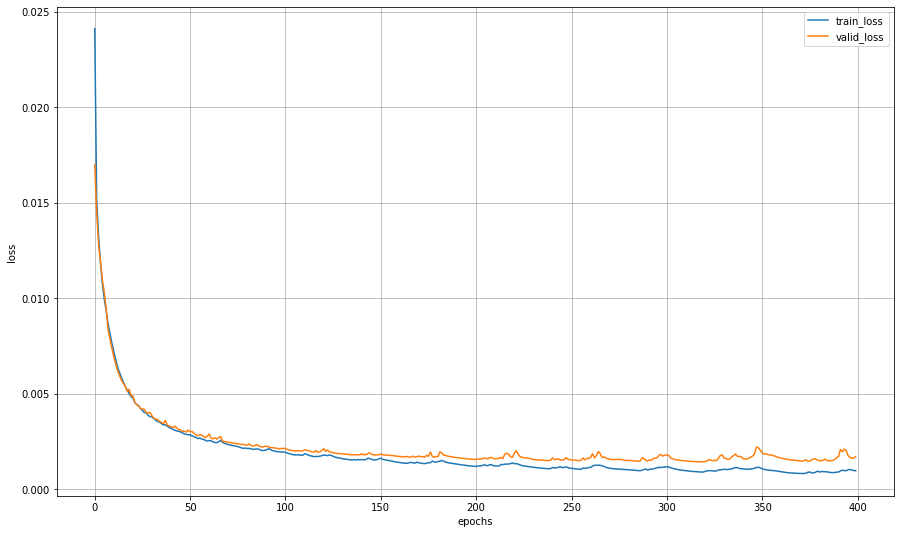

In [ ]:
plot(v_ae_train_history, v_ae_valid_history)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
#< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>

vanilla_ae.eval()
orign = []
predicted = []

for num, batch in enumerate(val_loader):
  preds = vanilla_ae(batch.view(-1, 6075).float().to(device))
  if num < 10:
    orign.append(batch[0].detach().numpy())
    predicted.append(preds[0][0].view(45, 45, 3).float().cpu().detach().numpy())


**Original images**

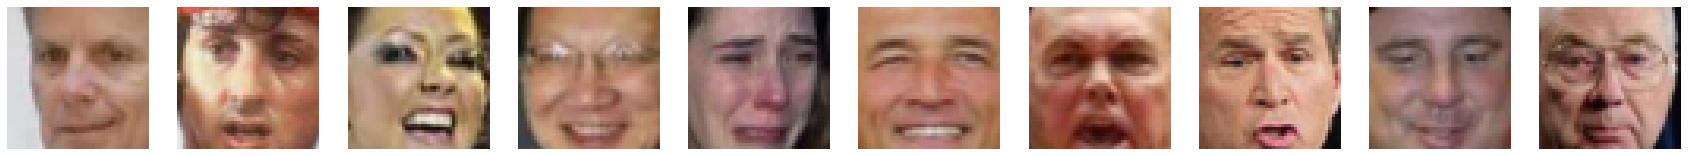

In [ ]:
ten_imgshow(orign, 0)

**Images after `vanilla_ae`**

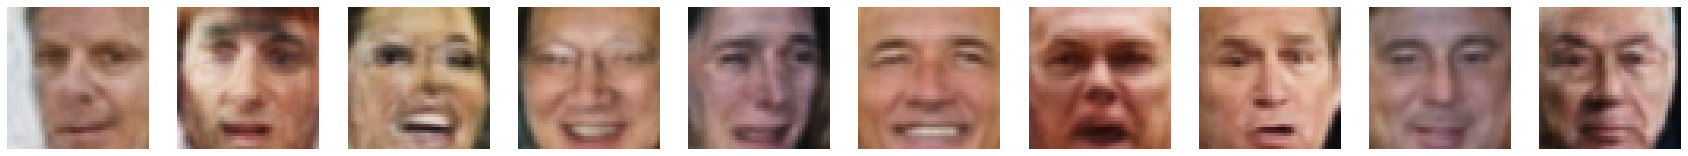

In [ ]:
ten_imgshow(predicted, 0)

Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как лаьентные векторы реальных фоток. Так что ридется рандом подогнать.

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, dim_code)
z_loader = torch.utils.data.DataLoader(z, batch_size=1)

z_predicted = []

vanilla_ae.eval()

for i in z_loader:
  output = vanilla_ae.decoder_output(vanilla_ae.decoder_hidden(i.view(-1, dim_code).float().to(device)))
  z_predicted.append(output[0].view(45, 45, 3).float().cpu().detach().numpy())

In [ ]:
dim_code, 14*14*3

(607, 588)

**Noise**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

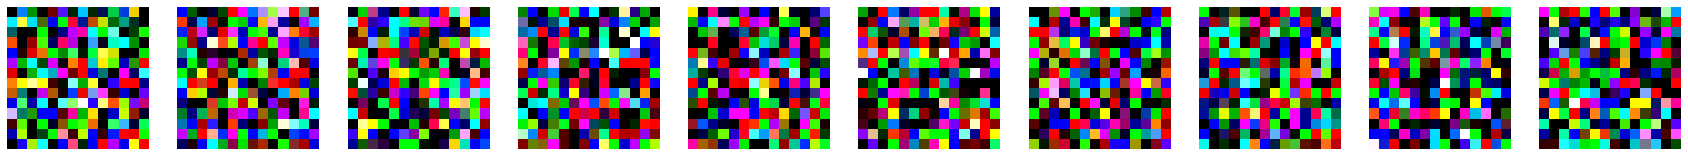

In [ ]:
ten_imgshow(z.reshape(25, 14, 14, 3), 0)

**Noise vectors after `vanilla_ae`**

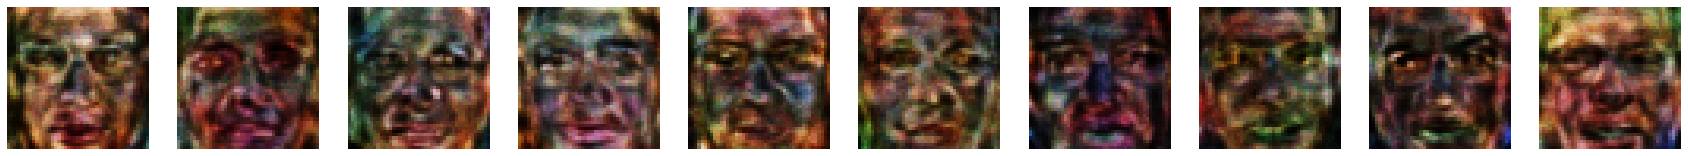

In [ ]:
ten_imgshow(z_predicted, 0)

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

**Frowning and Smiling faces indexes in data**

In [ ]:
frown_idxs = attrs[attrs['Frowning'] > 1]['Frowning'].index.tolist()
smile_idxs = attrs[attrs['Smiling'] > 1]['Smiling'].index.tolist()

**Smiling faces examples**

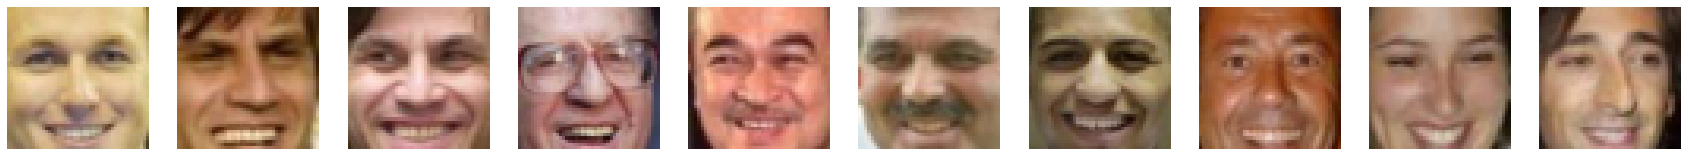

In [ ]:
ten_imgshow(data[smile_idxs], 0)

**Frowning faces examples**

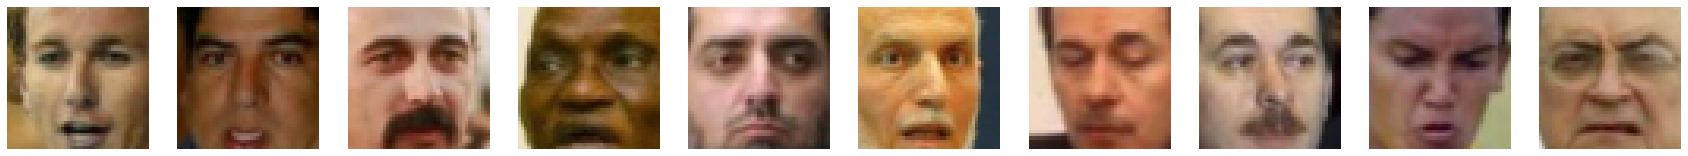

In [ ]:
ten_imgshow(data[frown_idxs], 0)

**Preparation the data**

In [ ]:
smile_ds = ImgData(data[smile_idxs[:60]])
frown_ds = ImgData(data[frown_idxs[:60]])
smile_loader = torch.utils.data.DataLoader(smile_ds, batch_size=1)
frown_loader = torch.utils.data.DataLoader(frown_ds, batch_size=1)

**Preparation of the 'smile latent vector'**

In [ ]:
smile_latent = []
frown_latent = []

vanilla_ae.eval()

for i in smile_loader:
  _, output = vanilla_ae(i.view(-1, 6075).float().to(device))
  smile_latent.append(output[0].float().cpu().detach().numpy())

for i in frown_loader:
  _, output = vanilla_ae(i.view(-1, 6075).float().to(device))
  frown_latent.append(output[0].float().cpu().detach().numpy())

mean_smile_latent = np.mean(np.vstack(smile_latent), axis=0)
mean_frown_latent = np.mean(np.vstack(frown_latent), axis=0)

frown_to_smile = (mean_smile_latent - mean_frown_latent).reshape(-1, dim_code)

**Vanilla autoencoder with 'smile latent vector' testing**

In [ ]:
changed_frown = []
change = torch.tensor(frown_to_smile).float().to(device)

for i in frown_loader:
  output, _ = vanilla_ae(i.view(-1, 6075).float().to(device), change)
  changed_frown.append(output[0].float().cpu().detach().numpy().reshape(45, 45, 3))

**Frowning faces**

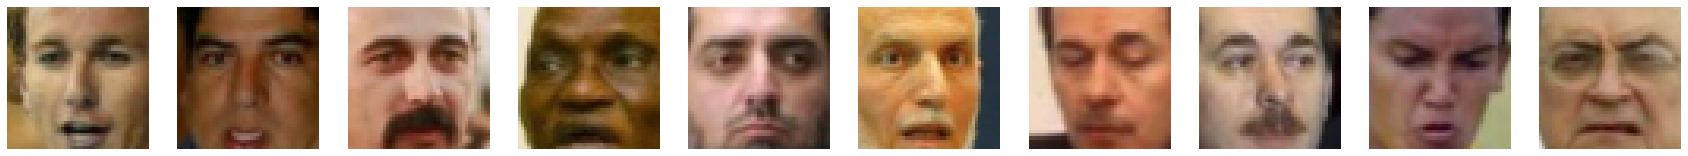

In [ ]:
ten_imgshow(data[frown_idxs[:20]], 0)

**Frowning faces after `vanilla_ae`**

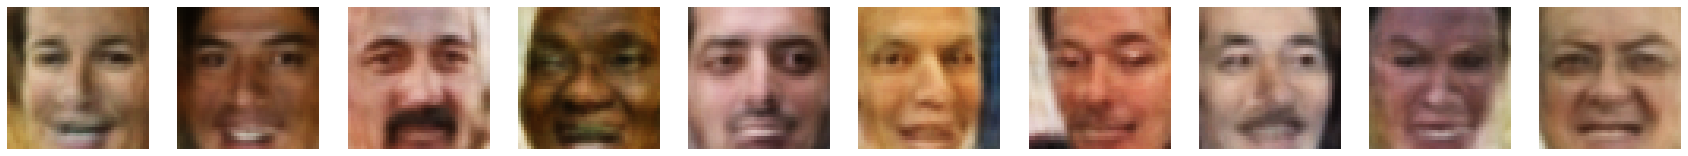

In [ ]:
ten_imgshow(changed_frown[:20], 0)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в lwf_deepfinetuned.txt =)

# Variational Autoencoder. (3 балла) 

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [ ]:
class VAE(nn.Module):
    def __init__(self, data_size, code_size):
        super(VAE, self).__init__()
        #<определите архитектуры encoder и decoder
        #помните, у encoder должны быть два "хвоста", 
        #т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        self.data_size = data_size
        self.fc_neck = 512
        self.code_size = code_size

        self.encoder_fc1 = nn.Linear(self.data_size, self.fc_neck)
        self.encoder_fc2 = nn.Linear(self.fc_neck, self.code_size * 2)

        self.decoder_fc1 = nn.Linear(self.code_size, self.fc_neck)
        self.decoder_fc2 = nn.Linear(self.fc_neck, self.data_size)

    def encode(self, x):
        #<реализуйте forward проход энкодера
        #в качестве ваозвращаемых переменных -- mu и logsigma>
        encoder_out = torch.relu(self.encoder_fc1(x))
        encoder_out = torch.relu(self.encoder_fc2(encoder_out)).view(-1, 2, self.code_size)

        mu = encoder_out[:, 0, :]
        logsigma = encoder_out[:, 1, :]
        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            #<засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            latent_vector = torch.randn_like(mu).mul(torch.exp(0.5*logsigma)).add_(mu)
            return latent_vector
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        #<реализуйте forward проход декодера
        #в качестве ваозвращаемой переменной -- reconstruction>
        decoder_out = torch.relu(self.decoder_fc1(z))
        reconstruction = torch.sigmoid(self.decoder_fc2(decoder_out))
        
        return reconstruction

    def forward(self, x):
        #<используя encode и decode, реализуйте forward проход автоэнкодера
        #в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)

        return reconstruction, mu, logsigma 

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return log_likelihood(x, reconstruction) + coeff * KL_divergence(mu, logsigma)

И обучим модель:

In [ ]:
from torchvision import datasets

transform = transforms.Compose([transforms.ToTensor()])

train_vae_mnist = datasets.MNIST(root='../sample_data',
                                train=True, 
                                download=True, 
                                transform=transform)
val_vae_mnist = datasets.MNIST(root='../sample_data',
                               train=False, 
                               download=False, 
                               transform=transform)

In [ ]:
class MNIST_Data(Dataset):
  def __init__(self, data):
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    self.img = self.data[index][0]

    return self.img

In [ ]:
train_vae_ds = MNIST_Data(train_vae_mnist)
val_vae_ds = MNIST_Data(val_vae_mnist)

In [ ]:
digit_img = train_vae_ds.__getitem__(0)
mnist_img_len = digit_img.shape[0] * digit_img.shape[1] * digit_img.shape[2]
code_size = 16
print(f'code_size = {code_size} \nmnist_img_len = {mnist_img_len}')

code_size = 16 
mnist_img_len = 784


In [ ]:
batch_size = 200

vae_train_loader = torch.utils.data.DataLoader(train_vae_ds, 
                                               batch_size=batch_size)

vae_val_loader = torch.utils.data.DataLoader(val_vae_ds,
                                             batch_size=batch_size)

In [ ]:
coeff = 0.1

criterion = loss_vae

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vae = VAE(mnist_img_len, code_size).to(device)

optimizer = optim.Adam(vae.parameters(), lr=1e-4)

print(f'device = {device}')

device = cuda


In [ ]:
vae_model, vae_train_history, vae_valid_history = train_vae(vae_train_loader,
                                                            vae_val_loader,
                                                            mnist_img_len,
                                                            optimizer,
                                                            criterion,
                                                            vae,
                                                            device,
                                                            400)

epoch : 0/400, train_loss = 53233.23466145834, valid_loss = 41507.75125
epoch : 50/400, avg_train_loss = 26284.48838580729, avg_valid_loss = 23834.536575
epoch : 100/400, avg_train_loss = 24902.190142447915, avg_valid_loss = 22481.964903515618
epoch : 150/400, avg_train_loss = 24231.989787890627, avg_valid_loss = 21805.27258515625
epoch : 200/400, avg_train_loss = 23832.690386523438, avg_valid_loss = 21402.208329492194
epoch : 250/400, avg_train_loss = 23562.851025677086, avg_valid_loss = 21131.836033125
epoch : 300/400, avg_train_loss = 23364.872343077255, avg_valid_loss = 20935.261552604166
epoch : 350/400, avg_train_loss = 23211.525541331845, avg_valid_loss = 20784.486985714288
epoch : 400/400, avg_train_loss = 23077.048025667318, avg_valid_loss = 20649.51873466797


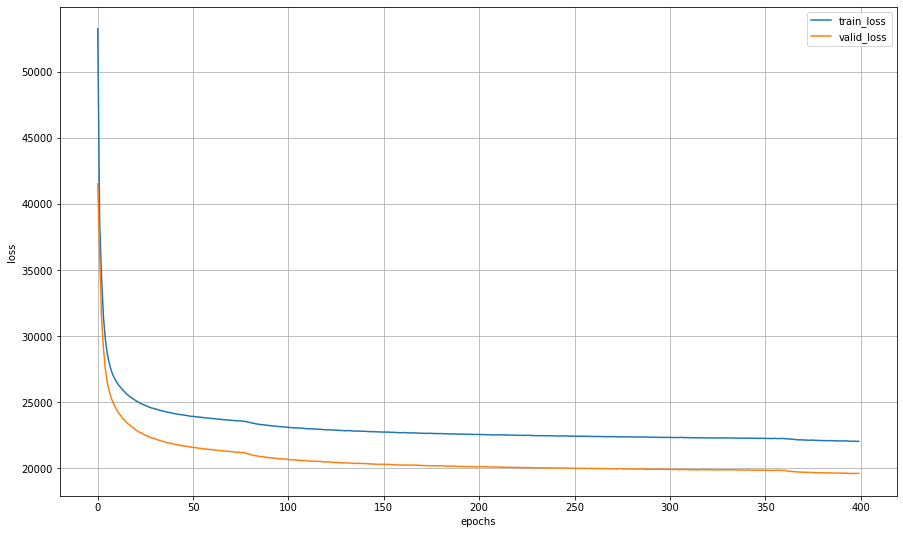

In [ ]:
plot(vae_train_history, vae_valid_history)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
#< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>

orign_digits = []
vae_predicted = []

vae_model.eval()

for i, img in enumerate(val_vae_ds):
  img = img.view(-1, mnist_img_len).to(device)
  preds = vae_model(img)[0]
  orign_digits.append(img.view(28, 28).cpu().detach().numpy())
  vae_predicted.append(preds.view(28, 28).cpu().detach().numpy())
  if i == 20:
    break

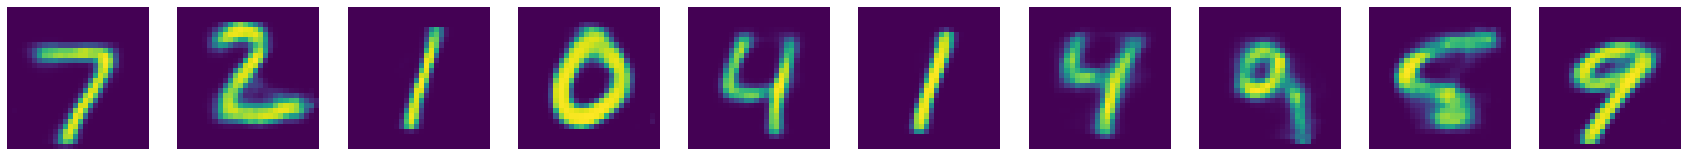

In [ ]:
ten_imgshow(vae_predicted, 0)

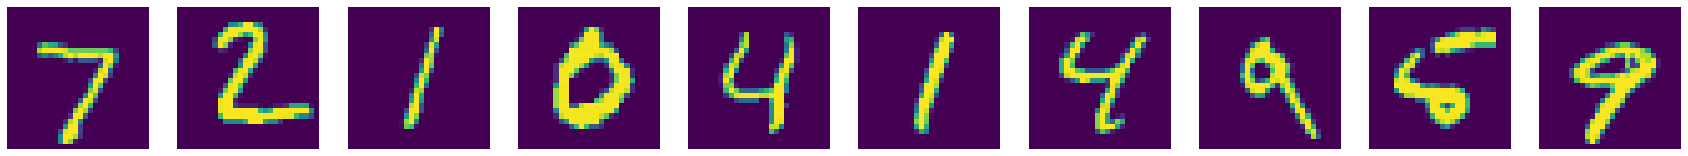

In [ ]:
ten_imgshow(orign_digits, 0)

And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

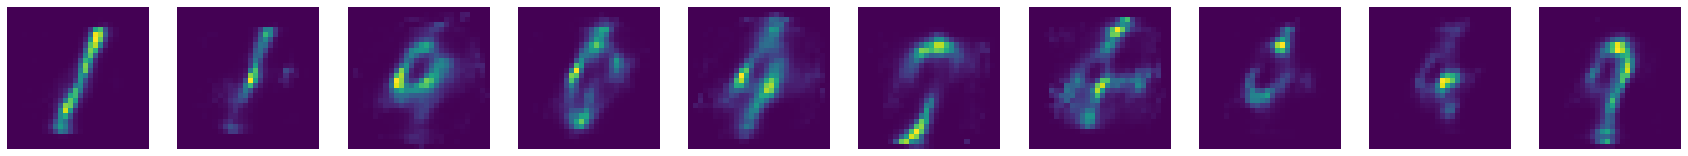

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, code_size) for i in range(10)])

vae_model.eval()

output = vae_model.decode(torch.tensor(z).float().to(device)).cpu().detach().numpy()

#<выведите тут полученные картинки>
ten_imgshow(output.reshape(-1, 28, 28), 0)

## Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы лиц в пространстве. 

Плюс давайте сделаем такую вещь: у вас есть файл с атрибутами lwf_deepfinetuned.txt, который скачался вместе с базой картинок. Там для каждой картинки описаны атрибуты картинки (имя человека, его пол, цвет кожи и т.п.). Когда будете визуализировать точки латентного пространства на картинке, возьмите какой-нибудь атрибут и покрасьте точки в соответствии со значем атрибута, соответствующего этой точке. 

Например, возьмем атрибут "пол". Давайте покрасим точки, которые соответствуют картинкам женщин, в один цвет, а точки, которые соответствуют картинкам мужчин -- в другой.

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам с разными атрибутами.

In [ ]:
class MNIST_Test_Data(Dataset):
  def __init__(self, data):
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    self.img = self.data[index][0]
    self.y = self.data[index][1]

    return self.img, self.y

In [ ]:
vae_model.eval()
mu_vectors = []
classes = []

vae_test_data = MNIST_Test_Data(val_vae_mnist)
digit_test_loader = torch.utils.data.DataLoader(vae_test_data,
                                                batch_size=1)

for num, (img, y) in enumerate(digit_test_loader):
  img = img.view(-1, mnist_img_len).float().to(device)
  mu = vae_model(img)[1]
  mu_vectors.append(mu.view(4, 4).cpu().detach().numpy())
  classes.append(y.cpu().detach().numpy())
  
classes = [x[0] for x in classes]

In [ ]:
embedded = []
d_size = int(len(mu_vectors)/5)

for i in range(d_size):
  embedded.append((TSNE(n_components=2).fit_transform(mu_vectors[i]), classes[i]))

In [ ]:
colors = {0: 'red',
          1: 'aqua',
          2: 'blue',
          3: 'yellow',
          4: 'black',
          5: 'magenta',
          6: 'green',
          7: 'orange',
          8: 'peru',
          9: 'silver'}

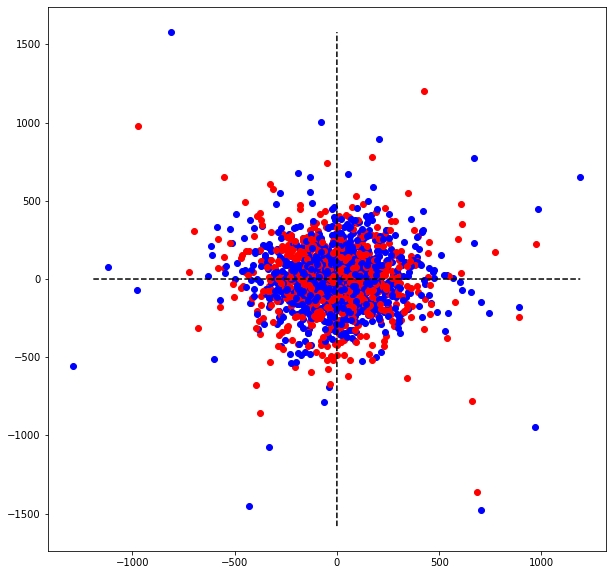

In [ ]:
max_x = 0
max_y = 0
test_num = [0, 2]
fig, ax = plt.subplots(figsize=(10,10))
for _, (coord, cls) in enumerate(embedded):
  if cls in test_num:
    x = coord[0:4, 0]
    y = coord[0:4, 1]
    scatter = ax.scatter(x, y, color=colors[cls])
    if max(x) > max_x:
      max_x = int(max(x))
    if max(y) > max_y:
      max_y = int(max(y))
plt.plot([x for x in range(-max_x, max_x)], 
         [0 for y in range(-max_x, max_x)], 
         color='black', linestyle='--')
plt.plot([0 for x in range(-max_y, max_y)], 
         [y for y in range(-max_y, max_y)], 
         color='black', linestyle='--')
plt.grid(False)
plt.show();

Что вы думаете о виде латентного представления?

Latent representation vectors have a normal distribution. The variance of vectors decreases towards the center (0, 0).

## Congrats v2.0!

# Conditional VAE (2 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



На всякий случай: это VAE, то есть, latent у него состоит из mu и sigma все еще.

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет
Здесь я предлагаю вам два вариана. Один попроще, другой -- посложнее, но поинтереснее =)

1. Использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/). Обучать conditional VAE на этом датасете, condition -- класс цифры. 

2. Использовать датасет лиц, с которым мы игрались выше. Condition -- пол/раса/улыбки/whatever из lfw_deepfinetuned.txt. 

Почему второй вариант "посложнее" -- потому что я сама еще не знаю, получится ли такой CVAE с лицами или нет =) Вы -- исследователи! (не ну это же проект, так и должно быть)

In [ ]:
<тут ваш код объявления CVAE, лосса, оптимизатора и тренировки>

## Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора картинки цифры 5 и 7, а для лиц людей -- восстановить лицо улыбающегося и хмурого человека или лица людей разного пола (смотря на чем был ваш кондишен)

In [ ]:
<тут нужно научиться сэмплировать из декодера цифры определенного класса>

Splendid! Вы великолепны!

Ну круто же, ну?

## Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
<ваш код получения латентных представлений, применения TSNE и визуализации>

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Image Morphing (1 балл) 

<a href="https://ibb.co/rxr9YgL"><img src="https://i.ibb.co/D92dhN6/1-6y-Okto2-BUp-ONJpk5x-LRMtw.png" alt="1-6y-Okto2-BUp-ONJpk5x-LRMtw" border="0"></a>

Предлагаю вам поиграться не только с улыбками, но и с получением из одного человека другого!

План:
1. Берем две картинки разных людей из датасета
2. Получаем их латентные представления X и Y
3. Складываем латентные представления с коэффициентом $\alpha$:
  $$\alpha X + (1-\alpha) Y$$
  где $\alpha$ принимает несколько значений от 0 до 1 
4. Визуализируем, как один человек превращается в другого!

In [ ]:
<тут ваш код>

# BONUS 2: Denoising (2 балла) 

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонусное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для того, чтобы поставить эксперимент, нужно взять ваш любимый датасет (датасет лиц или MSE с прошлых заданий или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

**Preparation of noisy data**

In [ ]:
noise_factor = 0.2

noise_data = data.copy()
check_data = data[:20].copy()

In [ ]:
def noise(img_dim, noise_factor):
  return img_dim + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img_dim.shape)

def add_noise(img_batch, device, noise_factor=0.2):
  noisy_batch = img_batch.detach().cpu().numpy().copy()
  for i in range(noisy_batch.shape[0]):
      noisy_batch[i] = noise(noisy_batch[i], noise_factor)
  return torch.tensor(noisy_batch).to(device)

In [ ]:
noise_ae_train_ds = ImgData(noise_data[train_idxs])
noise_ae_val_ds = ImgData(noise_data[val_idxs])

In [ ]:
noise_criterion = nn.MSELoss()

noise_autoencoder = Autoencoder(dim_code)

noise_optimizer = optim.Adam(noise_autoencoder.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

noise_autoencoder.to(device)
print(device)

cuda


In [ ]:
batch_size = 128

noise_train_loader = torch.utils.data.DataLoader(noise_ae_train_ds, 
                                                 batch_size=batch_size)

noise_val_loader = torch.utils.data.DataLoader(noise_ae_val_ds,
                                               batch_size=batch_size)

**The `denoise_ae` training**

In [ ]:
denoise_ae, den_ae_train_history, den_ae_val_history = train(noise_train_loader,
                                                             noise_val_loader,
                                                             data_dim,
                                                             noise_optimizer,
                                                             noise_criterion,
                                                             noise_autoencoder,
                                                             device,
                                                             400,
                                                             add_noise)

epoch : 0/400, train_loss = 0.023743867851704, valid_loss = 0.016299512192961715
epoch : 50/400, train_loss = 0.0034807750180992016, valid_loss = 0.003538675739296845
epoch : 100/400, train_loss = 0.0026190142141632646, valid_loss = 0.0029362126231370937
epoch : 150/400, train_loss = 0.002256452658561518, valid_loss = 0.0026605436578392982
epoch : 200/400, train_loss = 0.002123576451474464, valid_loss = 0.00271919104714124
epoch : 250/400, train_loss = 0.0020721609218898847, valid_loss = 0.003214888396628556
epoch : 300/400, train_loss = 0.0018273452402047634, valid_loss = 0.0025562068137029805
epoch : 350/400, train_loss = 0.0018406703756807979, valid_loss = 0.0029882022756196206
epoch : 400/400, train_loss = 0.0017182471529378679, valid_loss = 0.002742283068419922


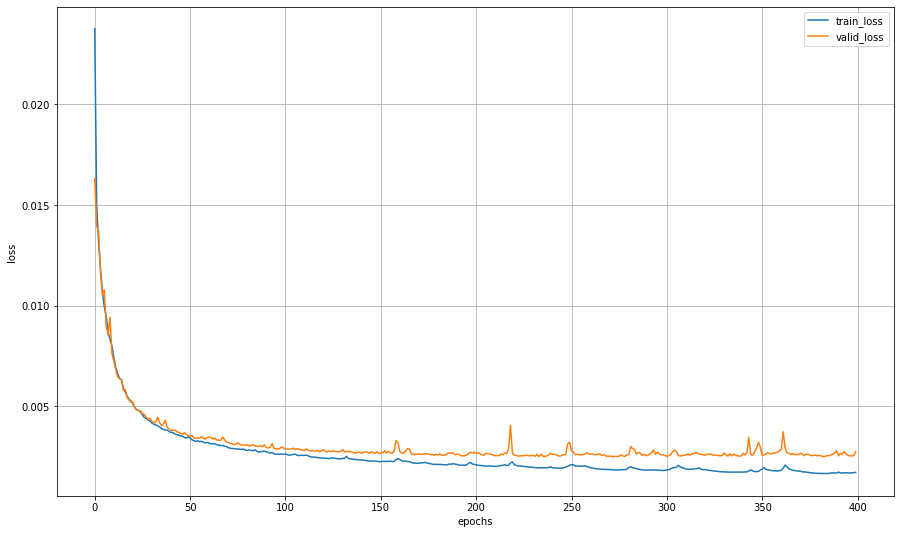

In [ ]:
plot(den_ae_train_history, den_ae_val_history)

**The `denoise_ae` test**

In [ ]:
denoise_ae.eval()
n_orign = []
n_predicted = []
n_noisy = []

check_ds = ImgData(check_data)
check_loader = torch.utils.data.DataLoader(check_ds, batch_size=1)

for num, batch in enumerate(check_loader):
  batch = batch.view(-1, 6075).float().to(device)
  noisy_batch = add_noise(batch, device)
  preds = denoise_ae(noisy_batch)
  if num < 10:
    n_orign.append(batch[0].view(45, 45, 3).float().detach().cpu().numpy())
    n_noisy.append(noisy_batch[0].view(45, 45, 3).float().detach().cpu().numpy())
    n_predicted.append(preds[0][0].view(45, 45, 3).float().cpu().detach().numpy())

**Noised images**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

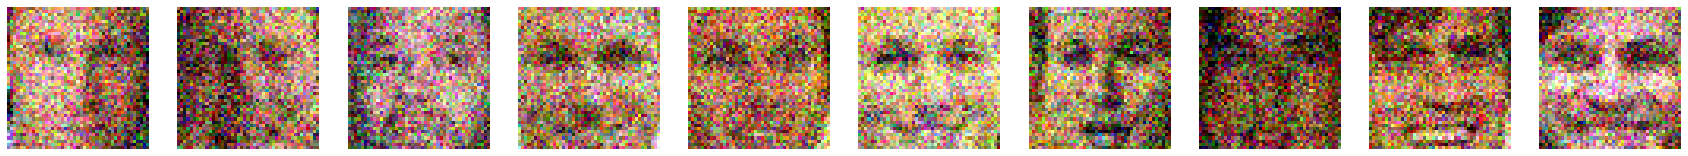

In [ ]:
ten_imgshow(n_noisy, 0)

**Denoised images**

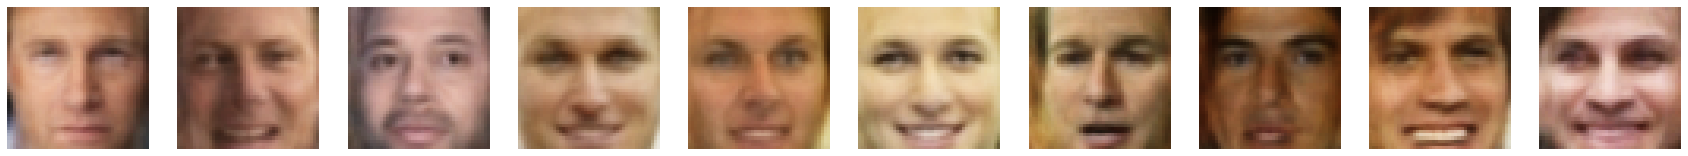

In [ ]:
ten_imgshow(n_predicted, 0)

**Original images**

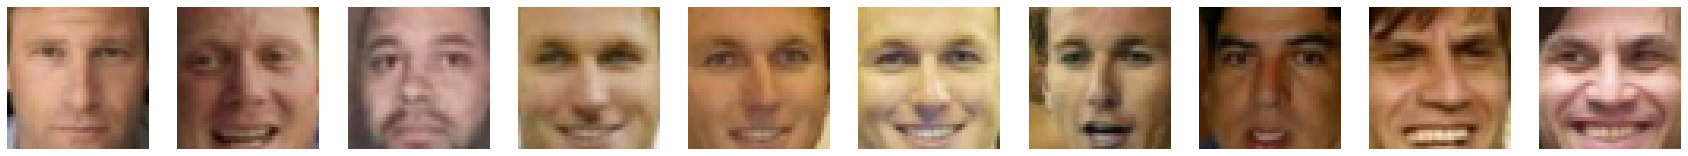

In [ ]:
ten_imgshow(n_orign, 0)

## Бонус 2.1: Occlusion (+еще 1 балл)

<a href="https://imgbb.com/"><img src="https://i.ibb.co/wYrKtQY/Screen-Shot-2020-06-04-at-5-06-35-PM.png" alt="Screen-Shot-2020-06-04-at-5-06-35-PM" border="0" width="300" height="300"></a>

Автоэнкодерами можно не только убирать шум, но и восстанавливать части картинки, которые чем-то закрыты! 

Эксперимент здесь такой: вместо наложения шума на картинку, "закрываем" часть картинки заплаткой и тренируем AE/VAE восстанавливать закрытую часть картинки.

Важно, чтобы заплатка была не очень большая. 

**Occlued data preparation**

In [ ]:
def add_occlude(img, device):
  occ_img = img.detach().clone()
  for i in range(occ_img.shape[3]):
    occ_img[0, 16:22, 21:30, i] = 1.0
  return occ_img.to(device)

check_ds = ImgData(check_data)
check_loader = torch.utils.data.DataLoader(check_ds, batch_size=1)

check_list = []
for batch in check_loader:
  #print(batch.shape)
  occ_img = add_occlude(batch, device)
  check_list.append(occ_img[0].float().detach().cpu().numpy())

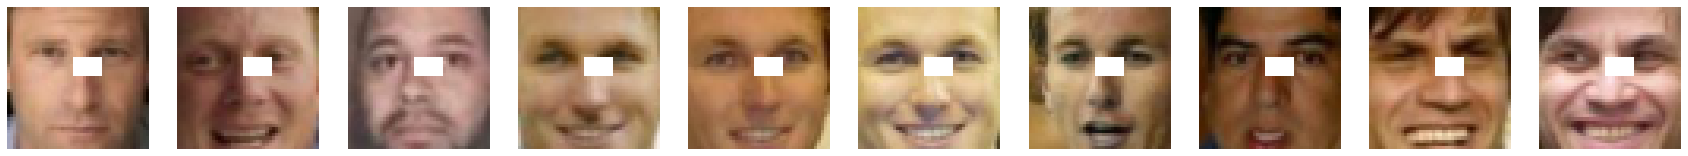

In [ ]:
ten_imgshow(check_list, 0)

In [ ]:
occlude_ae_train_ds = ImgData(data[train_idxs])
occlude_ae_val_ds = ImgData(data[val_idxs])

In [ ]:
occlude_criterion = nn.MSELoss()

occlude_autoencoder = Autoencoder(dim_code)

occlude_optimizer = optim.Adam(occlude_autoencoder.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

occlude_autoencoder.to(device)
print(device)

cuda


In [ ]:
batch_size = 128

occlude_train_loader = torch.utils.data.DataLoader(occlude_ae_train_ds, 
                                                 batch_size=batch_size)

occlude_val_loader = torch.utils.data.DataLoader(occlude_ae_val_ds,
                                               batch_size=batch_size)

**The `unocclude_ae` training**

In [ ]:
unocclude_ae, occl_ae_train_history, occl_ae_val_history = train(occlude_train_loader,
                                                                 occlude_val_loader,
                                                                 data_dim,
                                                                 occlude_optimizer,
                                                                 occlude_criterion,
                                                                 occlude_autoencoder,
                                                                 device,
                                                                 400,
                                                                 add_occlude)

epoch : 0/400, train_loss = 0.02408457755010171, valid_loss = 0.016558666003956682
epoch : 50/400, train_loss = 0.0028678155307803885, valid_loss = 0.003009991077262731
epoch : 100/400, train_loss = 0.0021170465926448985, valid_loss = 0.0022603654125261875
epoch : 150/400, train_loss = 0.0015082521005028702, valid_loss = 0.0018120719330562722
epoch : 200/400, train_loss = 0.0013387508203657008, valid_loss = 0.0017188546037124027
epoch : 250/400, train_loss = 0.0011903026182602822, valid_loss = 0.0016697153194053542
epoch : 300/400, train_loss = 0.0010732046860769525, valid_loss = 0.0016190505065467385
epoch : 350/400, train_loss = 0.0011442509568885463, valid_loss = 0.0017343894356773013
epoch : 400/400, train_loss = 0.0009969397306341275, valid_loss = 0.0017262364161156473


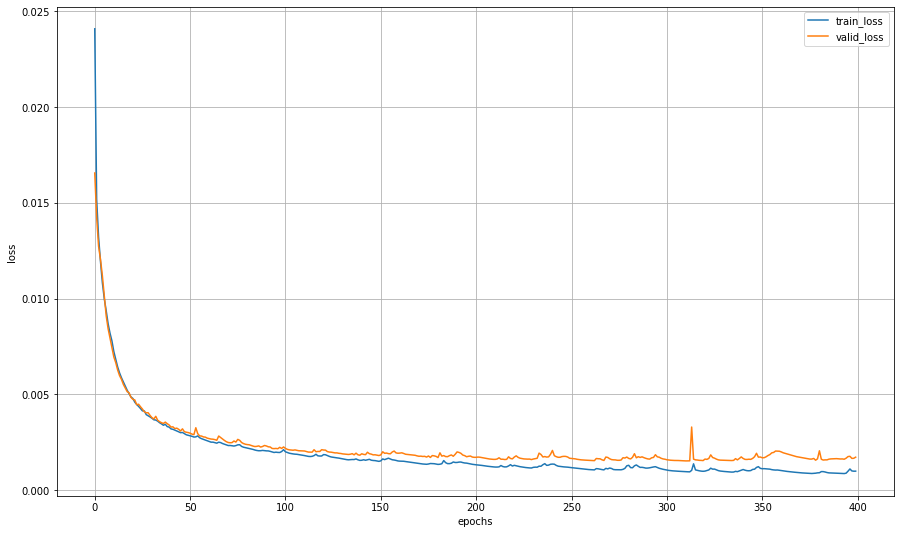

In [ ]:
plot(occl_ae_train_history, occl_ae_val_history)

**The `unocclude_ae` test**

In [ ]:
unocclude_ae.eval()
o_orign = []
o_predicted = []
occluded = []

check_ds = ImgData(check_data)
check_loader = torch.utils.data.DataLoader(check_ds, batch_size=1)

for num, batch in enumerate(check_loader):
  occluded_batch = add_occlude(batch, device)
  occluded_batch = occluded_batch.view(-1, 6075).float().to(device)
  batch = batch.view(-1, 6075).float().to(device)
  preds = unocclude_ae(occluded_batch)
  if num < 10:
    o_orign.append(batch[0].view(45, 45, 3).float().detach().cpu().numpy())
    occluded.append(occluded_batch[0].view(45, 45, 3).float().detach().cpu().numpy())
    o_predicted.append(preds[0][0].view(45, 45, 3).float().cpu().detach().numpy())

**Occluded faces**

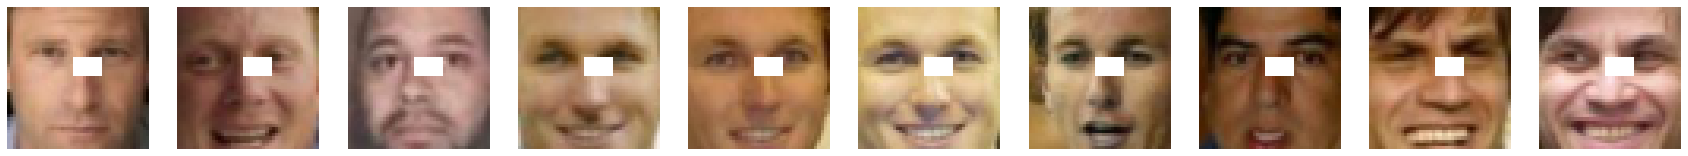

In [ ]:
ten_imgshow(occluded, 0)

**Un-occluded faces**

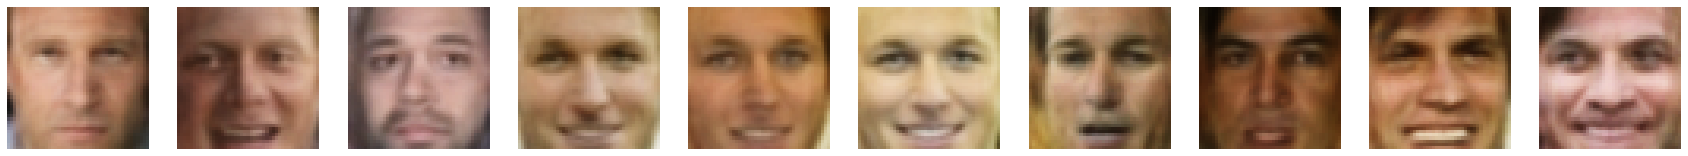

In [ ]:
ten_imgshow(o_predicted, 0)

**Original faces**

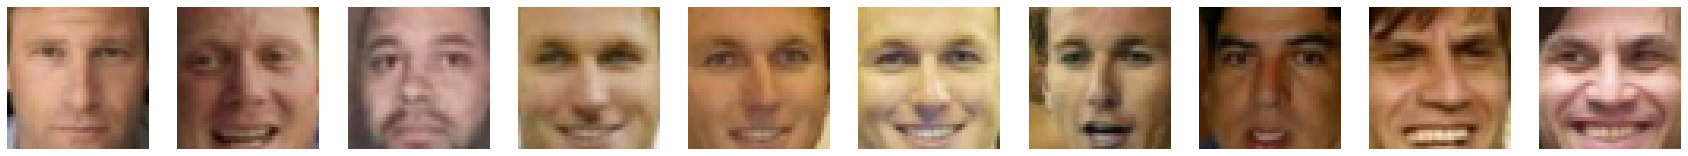

In [ ]:
ten_imgshow(o_orign, 0)

# Bonus 3: Image Retrieval (1 балл)

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest (sklearn.neighbors.LSHForest), например, с n_estimators=50
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>

# Bonus 4: Телеграм-бот (3 балла)

Вы можете написать телеграм-бота с функционалом AE. Например, он может добавлять к вашей фотографии улыбку или искать похожие на ваше лицо лица среди лиц датасета. 

Код бота должно быть можно проверить!

# Эпилог

здесь мы рассмотрели не все применения автоэнкодеров. Еще есть, например:

-- поиск аномалий
-- дополнение отсутствующих частей картины
-- работа с sequential данными (например, временными рядами)
-- гибриды ГАН+АЕ, которые активно изучаются в последнее время
-- использование латентных переменных АЕ в качестве фичей
...

Они не были частью этого проекта, потому что для их реализации пришлось бы больше возиться с датасетами. 

Но! Если вы хотите, вы, конечно, всегда можете реализовать еще что-то и получить за это еще допбаллы.

Надеюсь, вам понравилось!